In [25]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [26]:
exp = np.e
log = math.log

In [27]:
kmin = 0            # inidividual wealth
kmax = 10           # upper limit of capital grid 
na = 200            # number of grid points over assets a in [kmin,kmax]
a =  np.linspace(kmin, kmax, na)   # asset grid 
aeps = (a[1]-a[0])/na     #  test for corner solution
psi = 0.001         # parameter of utility function */
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tol = 0.0001        # percentage deviation of final solution 
tol1 = 1e-10        # tolerance for golden section search 
neg = -1e10         # initial value for value function 
nq = 30             # maximum number of iteration over K
#nq = 1
# Part 4: Start clock for measuring computational time 
start_time = time.time()


# Part 5: Parameterization of the model
# demographics
small = 0.00001
tfp = 1
r = 0.045        # initial value of the interest rate 
s = 2            # coefficient of relative risk aversion 
alpha = 0.36       # production elasticity of capital 
rep = 0.30       # replacement rate of pensions
delta = 0.10     # rate of depreciation 
tr = 20          # years during retired 
t = 40           # years of working time/


beta = 0.96         # discount factor 
tau = 0.2
kinit = 0       # capital stock at the beginning of first period
gamma = 0.5
eta = 2
G_gdp = 0.2
periods = 60

# initialization of aggregate variables
# Step 1 in Algorithm 9.1.1 in Heer/Maussner, DSGE Modeling (Springer) 
hbar = 1      # aggregate labor N
lbar = 0.2
lold = 0.2
kold = 100      # capital stock in previous iteration of K, initialization
hold = 1        # labor in previous iteration of N, initialization
r_init = beta**(-1) - 1
kbar = ((r_init + delta)/(alpha*tfp))**(1/(alpha-1)) * (hbar * lbar) # aggregate capital K
kq = np.zeros((nq,3))   # saves (K,N) in each outer iteration


_VI_method = 1       # 1 --- linear interpolation, 2 --- cubic spline 



In [28]:
def production(K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * K_prev**alpha * (H*L)**(1-alpha)

def wage_rate(K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * (1-alpha) * (K_prev)**alpha * (H*L)**(-alpha)

def interest_rate(K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * alpha * (H*L)**(1-alpha) * K_prev**(alpha-1) - delta

In [29]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  T = tax_revenue + G
  return T

In [30]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


# def next_value_function(k):
#   return vr_polate(k)


def value_function(next_value_interpolator, k, k_prev, l, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  c = (1-tau)*w*h*l + (1+r)*k_prev - k + tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k)

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


In [31]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, l, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.l = l
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.l, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

q: 0
q,i,K: [0, 99, 0.8588096394690239]
q,i,K: [0, 98, 0.8588096394690239]
q,i,K: [0, 97, 0.8588096394690239]
q,i,K: [0, 96, 0.8588096394690239]
q,i,K: [0, 95, 0.8588096394690239]
q,i,K: [0, 94, 0.8588096394690239]
q,i,K: [0, 93, 0.8588096394690239]
q,i,K: [0, 92, 0.8588096394690239]
q,i,K: [0, 91, 0.8588096394690239]
q,i,K: [0, 90, 0.8588096394690239]
q,i,K: [0, 89, 0.8588096394690239]
q,i,K: [0, 88, 0.8588096394690239]
q,i,K: [0, 87, 0.8588096394690239]
q,i,K: [0, 86, 0.8588096394690239]
q,i,K: [0, 85, 0.8588096394690239]
q,i,K: [0, 84, 0.8588096394690239]
q,i,K: [0, 83, 0.8588096394690239]
q,i,K: [0, 82, 0.8588096394690239]
q,i,K: [0, 81, 0.8588096394690239]
q,i,K: [0, 80, 0.8588096394690239]
q,i,K: [0, 79, 0.8588096394690239]
q,i,K: [0, 78, 0.8588096394690239]
q,i,K: [0, 77, 0.8588096394690239]
q,i,K: [0, 76, 0.8588096394690239]
q,i,K: [0, 75, 0.8588096394690239]
q,i,K: [0, 74, 0.8588096394690239]
q,i,K: [0, 73, 0.8588096394690239]
q,i,K: [0, 72, 0.8588096394690239]
q,i,K: [0, 71, 

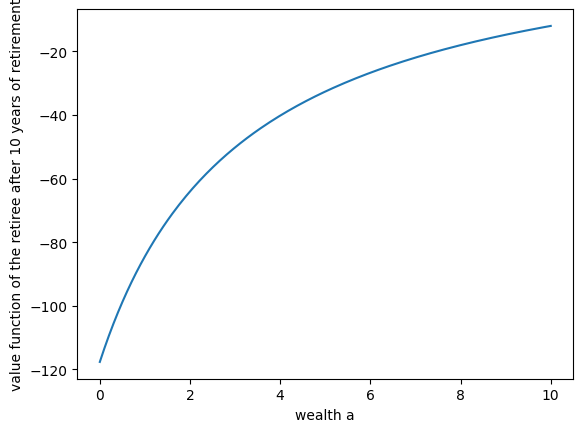

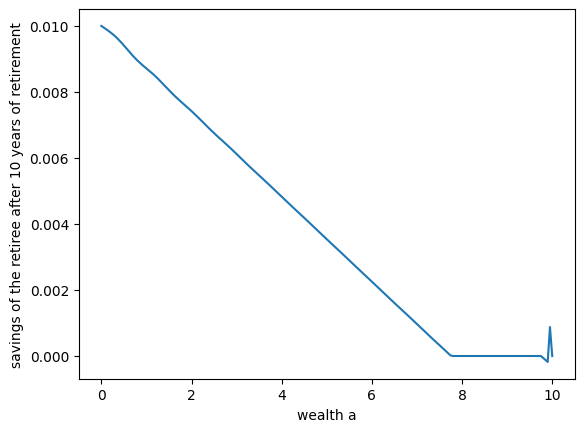

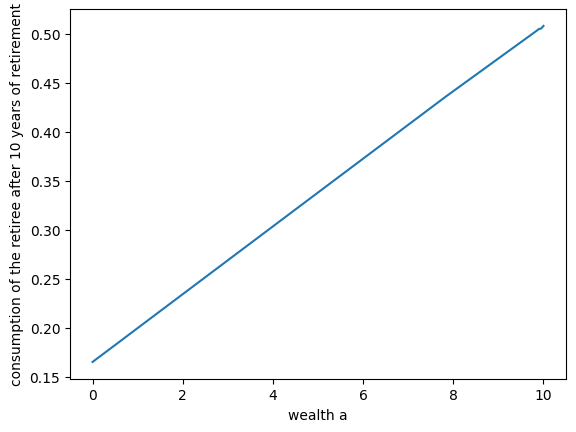

q,i,K: [0, 49, 0.8588096394690239]
q,i,K: [0, 48, 0.8588096394690239]
q,i,K: [0, 47, 0.8588096394690239]
q,i,K: [0, 46, 0.8588096394690239]
q,i,K: [0, 45, 0.8588096394690239]
q,i,K: [0, 44, 0.8588096394690239]
q,i,K: [0, 43, 0.8588096394690239]
q,i,K: [0, 42, 0.8588096394690239]
q,i,K: [0, 41, 0.8588096394690239]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
q: 1
q,i,K: [1, 99, 0.7224291611453519]
q,i,K: [1, 98, 0.7224291611453519]
q,i,K: [1, 97, 0.7224291611453519]
q,i,K: [1, 96, 0.7224291611453519]
q,i,K: [1, 95, 0.7224291611453519]
q,i,K: [1, 94, 0.7224291611453519]
q,i,K: [1, 93, 0.7224291611453519]
q,i,K: [1, 92, 0.7224291611453519]
q,i,K: [1, 91, 0.7224291611453519]
q,i,K: [1, 90, 0.7224291611453519]
q,i,K: [1, 89, 0.7224291611453519]
q,i,K: [1, 88, 0.7224291611453519]
q,i,K: [1, 87, 0.7224291611453519]
q,i,K: [1, 86, 0.7224291611453519]
q,i,K: [1, 85, 0.722429

In [32]:

# Part 6: iteration of policy function, wealth distribution,..
q = -1
crit = 1+tol
while q<nq-1 and crit>tol:
    q = q+1
    print("q: " + str(q))    
    crit = abs((kbar-kold)/kbar)    # percentage deviation of solution for K
                                    # in iteration q and q-1
    crit0 = abs((hbar-hold)/hbar)
    critl = abs((lbar-lold)/lbar)
    
    # Step 2 in Algorithm 9.1.1: computation of equilibrium values
    # for w, r, pen
    w = wage_rate(kbar, hbar, lbar)       # wage rate
    r = interest_rate(kbar, hbar, lbar)   # interest rate
    Y = production(K_prev = kbar, H = hbar, L = lbar)
    grants = G_gdp * Y
    T = transfer(K_prev = kbar, H = hbar, L = lbar, G = grants, tau = tau, w = w, r = r)/periods




    # pen = rep*(1-tau)*w*hbar*3/2    # pensions: balanced social security budget
    kold = kbar
    lold = lbar
    kq[q,0] = kbar
    kq[q,1] = hbar
    kq[q,2] = hbar

    
    
    # retired agents' value function  
    vr = np.zeros((na,periods))  # +1 value function 
    aropt = np.zeros((na,periods))  # optimal asset */
    cropt = np.zeros((na,periods))   # optimal consumption */
    lropt = np.zeros((na,periods))
    hropt = np.zeros((na,periods))
    for l in range(na):
        final_period_assets = (1-tau)*w*hbar*lbar + (1+r)*a[l] - tau*r*max(a[l], 0) + T
        vr[l,periods-1] = utility(final_period_assets ,lbar)
        cropt[l,periods-1] = final_period_assets
        lropt[l,periods-1] = lbar
        hropt[l,periods-1] = hbar
    
    
    # # workers' value function 
    # vw = np.zeros((na,t))
    # awopt = np.ones((na,t))
    # cwopt = np.zeros((na,t))
    # nwopt = np.zeros((na,t))
    
    
    # compute retiree's policy function 
    for i in  range(periods-1,0,-1):     # -1 instead? all ages i=T+TR,T+TR-2,..,T
        print("q,i,K: " + str([q,i,kbar]))
        vr_polate = interpolate.interp1d(a,vr[:,i], fill_value='extrapolate')
        # vr_polate = interpolate.interp1d(a,vr[:,i],kind='cubic', fill_value='extrapolate')
            
        m0 = 0

        #HERE
        for l in range(na): # asset holding at age i
            k0 = a[l]
            # triple ax, bx, cx: [ax,bx] bracket the maximum of Bellman eq.
            ax = 0
            bx = -1
            cx = -2
            v0 = neg
            m = max(-1,m0-2)
            # locate ax <= a' <= cx that bracket the maximum
            while ax>bx or bx>cx:
                m = m+1
                v1 = value_function(vr_polate, a[m], k0, lbar, hbar, w, r, tau, T)
                
                if v1>v0:
                    if m==0: # new value at lower bound a[0]
                        ax=a[m] 
                        bx=a[m]
                    else:
                        bx=a[m] 
                        ax=a[m-1]
                    
                    v0 = v1
                    m0=m   # monotonocity of the value function 
                    
                else:
                    cx=a[m]
                
                if m==na-1:
                    ax = a[m-1]
                    bx = a[m] 
                    cx = a[m] 
                
            
            
            if ax==bx:  # corner solution: a'=0?
                
                if value_function(vr_polate, ax, k0, lbar, hbar, w, r, tau, T)>value_function(vr_polate, aeps, k0, lbar, hbar, w, r, tau, T):
                    aropt[l,i-1]=0
                else:
                    # aropt[l,i-1] = GoldenSectionMax(value1,ax,aeps,cx,tol1)
                    aropt[l,i-1] = Search(vr_polate, value_function, ax, aeps, cx, tol1, k0, lbar, hbar, w, r, tau, T).find_max()
                
            elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
                if value_function(vr_polate, a[na-1], k0, lbar, hbar, w, r, tau, T)>value_function(vr_polate, a[na-1]-aeps, k0, lbar, hbar, w, r, tau, T):
                # if value1(a[na-1])>value1(a[na-1]-aeps):
                    aropt[l,i-1] = a[na-1]
                else:
                    #  aropt[l,i-1] = GoldenSectionMax(value1,a[na-2],kmax-aeps,kmax,tol1)
                     aropt[l,i-1] = Search(vr_polate, value_function, a[na-2], kmax-aeps, kmax, tol1, k0, lbar, hbar, w, r, tau, T).find_max()
            else:
                # aropt[l,i-1] = GoldenSectionMax(value1,ax,bx,cx,tol1)
                aropt[l,i-1] = Search(vr_polate, value_function, ax, bx, cx, tol1, k0, lbar, hbar, w, r, tau, T).find_max()
            

            k1 = aropt[l,i-1]
            # if l<0:
            #     n=0
            # vr[l,i-1] = value1(aropt[l,i-1])
            vr[l,i-1] = value_function(vr_polate, k1, k0, lbar, hbar, w, r, tau, T)
            # cropt[l,i-1] = (1+r)*a[l]+pen-k1
            cropt[l,i-1] = consumption(k_prev = k0, k = k1, h = hbar, l = lbar, w = w, r = r, tau = tau, T = T)
            
            #print("q,i,l,K" + str([q,i,l,kbar]))
        # print policy function
        if q==0 and i==10:
            
            plt.xlabel('wealth a')
            plt.ylabel('value function of the retiree after 10 years of retirement')
            plt.plot(a,vr[:,i-1])
            plt.show()
            
            
            plt.xlabel('wealth a')
            plt.ylabel('savings of the retiree after 10 years of retirement')
            plt.plot(a,aropt[:,i-1]-a)
            plt.show()
            
            
            plt.xlabel('wealth a')
            plt.ylabel('consumption of the retiree after 10 years of retirement')
            plt.plot(a,cropt[:,i-1])
            plt.show()
            
    # # compute worker's policy function 
    # for i in  range(t,0,-1):     # all ages i=T,T-1,..1T
    #     print("q,i,K: " + str([q,i,kbar]))   
    #     if i==t:
    #         vw0=vr[:,0]
    #     else:
    #         vw0=vw[:,i]
        
    #     if _VI_method == 1:
    #         vw_polate = interpolate.interp1d(a,vw0, fill_value='extrapolate')
    #     else: 
    #         vw_polate = interpolate.interp1d(a,vw0,kind='cubic', fill_value='extrapolate')
                
    #     m0 = 0 
        
    #     for l in range(na): # asset holding at age i
    #         k0 = a[l]
    #         # triple ax, bx, cx: [ax,bx] bracket the maximum of Bellman eq.
    #         ax = 0
    #         bx = -1
    #         cx = -2
    #         v0 = neg
    #         m = max(-1,m0-2)
    #         # locate ax <= a' <= cx that bracket the maximum
    #         while ax>bx or bx>cx:
    #             m = m+1
    #             v1 = value2(a[m])
        
    #             if v1>v0:
    #                 if m==0: # new value at lower bound a[0]
    #                     ax=a[m] 
    #                     bx=a[m]
    #                 else:
    #                     bx=a[m] 
    #                     ax=a[m-1]
                    
    #                 v0 = v1
    #                 m0=m   # monotonocity of the value function 
                    
    #             else:
    #                 cx=a[m]
                
    #             if m==na-1:
    #                 ax = a[m-1]
    #                 bx = a[m] 
    #                 cx = a[m] 
        
        
            
    #         if ax==bx:  # corner solution: a'=0?
    #             if value2(ax)>value2(aeps):
    #                 awopt[l,i-1]=0
    #             else:
    #                 awopt[l,i-1] = GoldenSectionMax(value2,ax,aeps,cx,tol1)
                
    #         elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
    #             if value2(a[na-1])>value2(a[na-1]-aeps):
    #                 awopt[l,i-1] = a[na-1]
    #             else:
    #                  awopt[l,i-1] = GoldenSectionMax(value2,a[na-2],kmax-aeps,kmax,tol1) 
    #         else:
    #             awopt[l,i-1] = GoldenSectionMax(value2,ax,bx,cx,tol1)
            

    #         k1 = awopt[l,i-1]
            
    #         n = 1/(1+gam)*(1-gam/((1-tau)*w)*(psi+(1+r)*k0-k1))
            
    #         if n<0:
    #             n=0
                
    #         cwopt[l,i-1] = (1-tau)*w*n+(1+r)*k0-k1
    #         nwopt[l,i-1] = n
    #         vw[l,i-1] = value2(awopt[l,i-1])
            
            
            #print("q,i,l,K" + str([q,i,l,kbar]))
        # if q==0 and i==10:
            
        #     plt.xlabel('wealth a')
        #     plt.ylabel('value function of the worker at age 10')
        #     plt.plot(a,vw[:,i-1])
        #     plt.show()
            
            
        #     plt.xlabel('wealth a')
        #     plt.ylabel('savings of the worker at age 10 year')
        #     plt.plot(a,awopt[:,i-1]-a)
        #     plt.show()
            
            
        #     plt.xlabel('wealth a')
        #     plt.ylabel('consumption of the worker at age 10')
        #     plt.plot(a,cwopt[:,i-1])
        #     plt.show()
        
        
        #     plt.xlabel('wealth a')
        #     plt.ylabel('labor supply of the worker at age 10')
        #     plt.plot(a,nwopt[:,i-1])
        #     plt.show()
        
    # Part 7: aggregation corresponding to     
    # Step 3-5 of algorithm 9.1.1   
    # computation of the aggregate capital stock and employment nbar 
    kgen = np.zeros(periods)
    lgen = np.zeros(periods)
    hgen = np.zeros(periods)
    cgen = np.zeros(periods)

    kgen[0] = kinit
    
    for j in range(periods-1):
        print(j)
        
        # if j<t: # worker
       
        ar_polate = interpolate.interp1d(a,aropt[:,j], fill_value='extrapolate')
        # aw_polate = interpolate.interp1d(a,awopt[:,j],kind='cubic', fill_value='extrapolate') 
            
        kgen[j+1] = ar_polate(kgen[j])
        #UPDATE LGEN, HGEN
        lgen[j] = lbar
        hgen[j] = hbar
        # n = 1/(1+gam)*(1-gam/((1-tau)*w)*(psi+(1+r)*kgen[j]-kgen[j+1]))
        # ngen[j] = n
        # cgen[j] = (1-tau)*w*n + (1+r)*kgen[j] - kgen[j+1]
        cgen[j] = consumption(k_prev = kgen[j], k = kgen[j+1], h = hgen[j], l = lgen[j], w = w, r = r, tau = tau, T = T)
        # else: # retired
        #     if _VI_method == 1:
        #         ar_polate = interpolate.interp1d(a,aropt[:,j-t], fill_value='extrapolate')
        #     else: 
        #         ar_polate = interpolate.interp1d(a,aropt[:,j-t],kind='cubic', fill_value='extrapolate') 
            
        #     kgen[j+1] = ar_polate(kgen[j])
        #     cgen[j] = (1+r)*kgen[j] + pen - kgen[j+1]
    final_period_assets = (1-tau)*w*hbar*lbar + (1+r)*kgen[periods-1] - tau*r*max(a[l], 0) + T

    cgen[periods-1] = final_period_assets
    
    knew = np.mean(kgen)
    
    # update aggregate variables
    kbar = phi*kold + (1-phi)*knew
    lnew = np.mean(lgen)*3/3 # workers have share 2/3 in total population
    lbar = phi*lold + (1-phi)*lnew
   

print("Solution for aggregate capital stock K: " + str(kbar))
print("Solution for aggregate labor N: " + str(lbar))

# plotting the value and policy function

fig, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].set_xlabel('age')
axes[0].set_ylabel('wealth a')
axes[0].plot(kgen)
axes[1].set_xlabel('age')
axes[1].set_ylabel('consumption')
axes[1].plot(cgen)
plt.show()                


plt.xlabel('age')
plt.ylabel('labor')
plt.plot(lgen)
plt.show()
        
print("runtime: --- %s seconds ---" % (time.time() - start_time))    
sec = (time.time() - start_time)
ty_res = time.gmtime(sec)
res = time.strftime("%H : %M : %S", ty_res)
print(res)
  